In [3]:
import pandas as pd
import numpy as np
import requests

## Tutorial

In [4]:
def clean(x,y):
 df = pd.DataFrame(x.iloc[0,0])
 df = df.loc[:, df.columns.str.contains(y)]
 df = pd.json_normalize(df[y])
 df = pd.DataFrame(df.raw)
 df.columns=[y]
 return(df)

In [12]:
url = "https://yh-finance.p.rapidapi.com/stock/v2/get-financials" 
querystring = {"symbol": "AAPL"}
headers = {
"X-RapidAPI-Key": "2b16489d50msh77e266df0975dcap19d2a0jsnb4e17362a69d",
"X-RapidAPI-Host": "yh-finance.p.rapidapi.com"}

response = requests.request("GET", url, headers=headers, params=querystring)

"\nebit = clean(incomestatement,'incomeBeforeTax')\ndepreciation = clean(cashflow, 'depreciation')\ncapex = clean(cashflow,'capitalExpenditures')\n"

In [14]:
df = response.json()
df1 = pd.json_normalize(df)

cashflow = df1.loc[:, df1.columns.str.contains('cashflowStatementHistoryQuarterly.cashflowStatements')]
incomestatement = df1.loc[:, df1.columns.str.contains('incomeStatementHistory.incomeStatementHistory')]

ebit = clean(incomestatement,'incomeBeforeTax')
depreciation = clean(cashflow, 'depreciation')
capex = clean(cashflow,'capitalExpenditures')


In [20]:
df_full = pd.concat([ebit, depreciation, capex], axis=1)

In [21]:
df_full

,incomeBeforeTax,depreciation,capitalExpenditures
0,119103000000,2916000000,-3787000000
1,109207000000,2865000000,-3289000000
2,67091000000,2805000000,-2102000000
3,65737000000,2737000000,-2514000000


In [23]:
mean_capex = df_full['capitalExpenditures'].mean()

In [24]:
mean_capex

-2923000000.0

In [28]:
df_full_1 = df_full.iloc[0:1].copy()

df_full_1['Average Capex'] = mean_capex
df_full_1['Owners Earnings'] = df_full_1['incomeBeforeTax'] + df_full_1['depreciation'] - df_full_1['Average Capex']

In [29]:
df_full_1

,incomeBeforeTax,depreciation,capitalExpenditures,Average Capex,Owners Earnings
0,119103000000,2916000000,-3787000000,-2.923000e+09,1.249420e+11


In [30]:
def compound(x,y):
    z= (1+x)**y
    return(z)
def discount(x,y):
    z= 1/(1+x)**y
    return(z)

In [36]:
terms = 5
compound_rate = 0.1
discount_rate = 0.05

dfc = []
for y in range(1, terms+1):
    z = compound(compound_rate,y)
    dfc.append(z)
    
dfc1 = pd.DataFrame(dfc)
    
dfd = []
for y in range(1,terms+1):
 z = discount(discount_rate,y)
 dfd.append(z)
    
dfd1 = pd.DataFrame(dfd)

calcs_table = pd.concat([dfc1,dfd1],axis=1)
calcs_table.columns=["Compound","Discount"]

In [ ]:
calcs_table["Amounts"] = calcs_table['Compound'] * calcs_table['Discount']
calcs_table1 = calcs_table.append(calcs_table.sum().rename('Total'))
DCF_multiplier = pd.DataFrame(calcs_table1['Amounts'].tail(1)).reset_index(drop=True)
DCF_multiplier.columns=["DCF_multiplier"]

In [41]:
calcs_table1

,Compound,Discount,Amounts
0,1.10000,0.952381,1.047619
1,1.21000,0.907029,1.097506
2,1.33100,0.863838,1.149768
3,1.46410,0.822702,1.204519
4,1.61051,0.783526,1.261877
Total,6.71561,4.329477,5.761288


In [42]:
DCF_multiplier

,DCF_multiplier
0,5.761288


In [49]:
PV_multiplier = pd.DataFrame(calcs_table['Amounts'].tail(1)).reset_index(drop=True)
PV_multiplier.columns=["PV_multiplier"]
PV_multiplier = PV_multiplier['PV_multiplier']/discount_rate

In [50]:
PV_multiplier

0    25.237535
Name: PV_multiplier, dtype: float64

In [52]:
final_df = pd.concat([df_full_1,PV_multiplier,DCF_multiplier],axis=1)
final_df['OE*PV'] = final_df['Owners Earnings']*final_df['PV_multiplier']
final_df['OE*DCF'] = final_df['Owners Earnings']*final_df['DCF_multiplier']
final_df['Intrinsic Value'] = final_df['OE*PV'] + final_df['OE*DCF']

In [53]:
final_df

,incomeBeforeTax,depreciation,capitalExpenditures,Average Capex,Owners Earnings,PV_multiplier,DCF_multiplier,OE*PV,OE*DCF,Intrinsic Value
0,119103000000,2916000000,-3787000000,-2.923000e+09,1.249420e+11,25.237535,5.761288,3.153228e+12,7.198268e+11,3.873055e+12


## Mine

### yfinance method, not working as of 02/03/2023

In [54]:
%%capture
!pip install yfinance
import yfinance as yf

In [55]:
msft = yf.Ticker("S32.AX")

In [56]:
msft.dividends

Date
2016-09-15 00:00:00+10:00    0.013200
2017-03-09 00:00:00+11:00    0.047648
2017-09-14 00:00:00+10:00    0.079843
2018-03-08 00:00:00+11:00    0.038412
2018-09-13 00:00:00+10:00    0.086581
2019-03-07 00:00:00+11:00    0.023970
2019-09-12 00:00:00+10:00    0.041051
2020-03-05 00:00:00+11:00    0.016737
2020-09-10 00:00:00+10:00    0.013689
2021-03-11 00:00:00+11:00    0.018088
2021-09-09 00:00:00+10:00    0.027141
2022-03-10 00:00:00+11:00    0.119486
2022-09-15 00:00:00+10:00    0.030000
Name: Dividends, dtype: float64

In [62]:
msft.actions

,Dividends,Stock Splits
Date,,
2016-09-15 00:00:00+10:00,0.013200,0.0
2017-03-09 00:00:00+11:00,0.047648,0.0
2017-09-14 00:00:00+10:00,0.079843,0.0
2018-03-08 00:00:00+11:00,0.038412,0.0
2018-09-13 00:00:00+10:00,0.086581,0.0
2019-03-07 00:00:00+11:00,0.023970,0.0
2019-09-12 00:00:00+10:00,0.041051,0.0
2020-03-05 00:00:00+11:00,0.016737,0.0
2020-09-10 00:00:00+10:00,0.013689,0.0


In [60]:
#msft.shares

In [61]:
msft.cashflow

Exception: yfinance failed to decrypt Yahoo data response

### yahooquery

In [63]:
%%capture

!pip install yahooquery

In [64]:
from yahooquery import Ticker

In [97]:
s32 = Ticker("S32.AX")

In [95]:
df_full

,incomeBeforeTax,depreciation,capitalExpenditures
0,119103000000,2916000000,-3787000000
1,109207000000,2865000000,-3289000000
2,67091000000,2805000000,-2102000000
3,65737000000,2737000000,-2514000000


In [125]:
details = ['CapitalExpenditure', 'AccumulatedDepreciation',  'ReconciledDepreciation', 'EBIT']
df_s32 = s32.get_financial_data(details, trailing=False).drop(columns=['periodType', 'currencyCode'])
df_s32 = df_s32.rename(columns={'asOfDate' : 'Year'})
df_s32.set_index('Year')

,AccumulatedDepreciation,CapitalExpenditure,EBIT,ReconciledDepreciation
Year,,,,
2019-06-30,-1.403700e+10,-756000000.0,9.850000e+08,757000000.0
2020-06-30,-1.474000e+10,-773000000.0,3.010000e+08,739000000.0
2021-06-30,-1.259300e+10,-591000000.0,1.740000e+08,720000000.0
2022-06-30,-1.312200e+10,-596000000.0,3.845000e+09,624000000.0


In [99]:
aapl.get_financial_data(details, trailing=False)['CapitalExpenditure'].mean()

-9899250000.0

In [115]:
df_s32.columns

Index(['asOfDate', 'AccumulatedDepreciation', 'CapitalExpenditure', 'EBIT',
       'ReconciledDepreciation'],
      dtype='object')

In [122]:
df_s32.rename({'EBIT' : 'Stuff'}, axis=1)

,asOfDate,AccumulatedDepreciation,CapitalExpenditure,Stuff,ReconciledDepreciation
symbol,,,,,
S32.AX,2019-06-30,-1.403700e+10,-756000000.0,9.850000e+08,757000000.0
S32.AX,2020-06-30,-1.474000e+10,-773000000.0,3.010000e+08,739000000.0
S32.AX,2021-06-30,-1.259300e+10,-591000000.0,1.740000e+08,720000000.0
S32.AX,2022-06-30,-1.312200e+10,-596000000.0,3.845000e+09,624000000.0


#### Discounted Cash Flow (DCF)

In [321]:
#To the determination of an intrinsic stock value

##### Beta risk factor

In [317]:
from sklearn.linear_model import LinearRegression

In [318]:
def beta_risk(stock, stock_name, span='1y', typed=False):
    """
    Requires packages yahooquery and sklearn.linear_model.
    Returns the beta risk facotr of the stock against the S&P/ASX 200 index. 
    Span kwarg based on yahooquery period kwargs. See: https://yahooquery.dpguthrie.com/guide/ticker/historical/
    """
    
    data = Ticker([stock, '^AXJO'])
    df = data.history(period=span).unstack(level=0)
    df_close = df['adjclose'].pct_change().dropna()
    
    X = np.array(df_close['^AXJO']).reshape((-1,1))
    y = np.array(df_close[stock])
        
    model = LinearRegression().fit(X, y)
    
    if typed == True:
        print(stock_name, 'Beta: ', model.coef_[0])
        
    return model.coef_[0]

##### WACC (discount rate)

In [319]:
# WACC = E / (D + E) * (r_f + Beta * (r_m - r_f)) + D / (D + E) * i * (1-t)

#Cost of equity
MARKET_RETURN = 0.132 #Source: https://files.marketindex.com.au/files/statistics/historical-returns-infographic-2022.pdf
RISK_FREE_RATE = float(Ticker('^IRX').history(period='1d')['close']) / 100 #Returns previous day's close price of 13 week US treasury bond

#Cost of debt
COD = 0.1357 #Source: https://www.gurufocus.com/term/wacc/ASX:S32/WACC-/South32-Ltd

In [311]:
def wacc(stock, stock_name, span='1y'):
    MARKET_RETURN = 0.132 #Source: https://files.marketindex.com.au/files/statistics/historical-returns-infographic-2022.pdf
    RISK_FREE_RATE = float(Ticker('^IRX').history(period='1d')['close']) / 100 #Returns previous day's close price of 13 week US treasury bond
    COD = 0.1357 #Source: https://www.gurufocus.com/term/wacc/ASX:S32/WACC-/South32-Ltd
    
    data = Ticker(stock, trailing=False)   
    stock_finance = data.get_financial_data(['StockholdersEquity', 'TotalDebt'], trailing=False)
    
    Equity = stock_finance['StockholdersEquity'][-1]
    Debt = stock_finance['TotalDebt'][-1]
    
    beta = beta_risk(stock, stock_name, span)
    
    weight_average_cost_of_capital = Equity / (Debt + Equity)  * (RISK_FREE_RATE + beta * (MARKET_RETURN - RISK_FREE_RATE)) + Debt / (Debt + Equity) * COD
    return weight_average_cost_of_capital

### Other

In [309]:
data = Ticker(['S32.AX', '^IRX'], trailing=False)
df = data.history(period='1y').unstack(level=0)
df

open          high           low         close         \
symbol     S32.AX   ^IRX S32.AX   ^IRX S32.AX   ^IRX S32.AX   ^IRX   
date                                                                 
2022-03-03   5.15  0.310   5.17  0.335  5.055  0.298   5.12  0.335   
2022-03-04   5.07  0.325   5.17  0.325  5.060  0.295   5.17  0.305   
2022-03-07   5.35  0.315   5.44  0.320  5.260  0.295   5.36  0.305   
2022-03-08   5.27  0.363   5.29  0.363  4.990  0.350   5.01  0.360   
2022-03-09   4.90  0.360   5.02  0.370  4.880  0.348   4.93  0.370   
...           ...    ...    ...    ...    ...    ...    ...    ...   
2023-02-28   4.38  4.720   4.40  4.730  4.310  4.710   4.34  4.710   
2023-03-01   4.33  4.715   4.49  4.735  4.330  4.700   4.47  4.725   
2023-03-02   4.60  4.720   4.72  4.733  4.550  4.713   4.70  4.723   
2023-03-03   4.67    NaN   4.76    NaN  4.670    NaN   4.76    NaN   
2023-03-04   4.67  4.708   4.76  4.728  4.670  4.705   4.76  4.718   

                volume       adjclose        dividends       
symbol          S32.AX ^IRX    S32.AX   ^IRX    S32.AX ^IRX  
date                                                         
2022-03-03  29060593.0  0.0  4.961215  0.335       0.0  0.0  
2022-03-04  27199383.0  0.0  5.009665  0.305       0.0  0.0  
2022-03-07  28388685.0  0.0  5.193773  0.305       0.0  0.0  
2022-03-08  33617915.0  0.0  4.854627  0.360       0.0  0.0  
2022-03-09  33859093.0  0.0  4.777108  0.370       0.0  0.0  
...                ...  ...       ...    ...       ...  ...  
2023-02-28  20308818.0  0.0  4.340000  4.710       0.0  0.0  
2023-03-01  14456219.0  0.0  4.470000  4.725       0.0  0.0  
2023-03-02  46319078.0  0.0  4.700000  4.723       0.0  0.0  
2023-03-03  14323218.0  NaN  4.760000    NaN       0.0  NaN  
2023-03-04  14272921.0  0.0  4.760000  4.718       0.0  0.0  

[260 rows x 14 columns]

In [281]:
data = Ticker(['AAPL', '^GSPC'])
df = data.history(period='5y', interval='1mo').unstack(level=0)
df_close = df['adjclose'].pct_change().dropna()
X = np.array(df_close['^GSPC']).reshape((-1,1))
y = np.array(df_close['AAPL']).reshape((-1,1))

In [282]:
model = LinearRegression().fit(X, y)

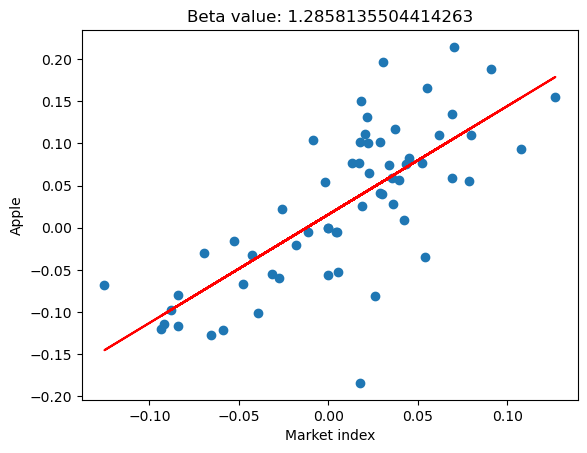

In [283]:
plt.scatter(X, y)
plt.plot(X, model.intercept_ + X * model.coef_, color = 'red')
plt.ylabel('Apple')
plt.xlabel('Market index')
plt.title('Beta value: {}'.format(model.coef_[0][0]))
plt.show()